<a href="https://colab.research.google.com/github/sebauribeo/deteccionFraudes/blob/Staging/evaluacion_3_machine_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# *1.- Importación de Librerías y Carga de Datos*

En esta sección, importamos todas las librerías necesarias para el análisis de datos, preprocesamiento, modelado y evaluación. También cargamos el conjunto de datos que utilizaremos para entrenar y probar nuestro modelo.

In [1]:
!pip install catboost tensorflow

# Importar librerías esenciales para manejo de datos y visualización
import pandas as pd  # Manejo de datos en formato tabular
import numpy as np  # Operaciones numéricas
import matplotlib.pyplot as plt  # Generación de gráficos
import seaborn as sns  # Gráficos avanzados basados en Matplotlib

# Librerías para preprocesamiento y modelos clásicos
from sklearn.preprocessing import LabelEncoder, StandardScaler  # Codificación y escalado de datos
from sklearn.model_selection import train_test_split  # División de datos en entrenamiento y prueba
from sklearn.metrics import classification_report, confusion_matrix  # Métricas para evaluar modelos

# Librería para manejo del desbalanceo de clases
from imblearn.over_sampling import SMOTE  # Generación de datos sintéticos para balancear clases

# Librerías de PyTorch para redes neuronales
import torch  # Biblioteca principal de PyTorch
import torch.nn as nn  # Definición de redes neuronales
from torch.utils.data import TensorDataset, DataLoader  # Manejo eficiente de datasets y minibatches

# Importación de modelos clásicos
from sklearn.linear_model import LogisticRegression  # Regresión logística
from sklearn.tree import DecisionTreeClassifier  # Árbol de decisión
from catboost import CatBoostClassifier  # Modelo avanzado de CatBoost

# Importación de TensorFlow
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout

# Importación para descargar archivo
from google.colab import files

# Cargar el dataset
data = pd.read_csv('/content/financial_dataset.csv')

# *2.- Preprocesamiento de Datos*
En esta sección, realizamos un análisis inicial de los datos, manejamos valores faltantes y codificamos variables categóricas. Creamos características adicionales que pueden ser útiles para el modelo y seleccionamos las características relevantes. Finalmente, estandarizamos los datos para prepararlos para el entrenamiento.
## a.- Exploración Inicial

In [2]:
# Visualizar las primeras filas del dataset
data.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


## b.- Manejo de Valores Faltantes

In [3]:
# Verificar valores faltantes en cada columna
print("Valores faltantes por columna:")
print(data.isnull().sum())

# Eliminar filas con valores faltantes en 'isFraud'
data = data.dropna(subset=['isFraud'])

# Opcional: También podemos eliminar filas con valores faltantes en las características
data = data.dropna()


Valores faltantes por columna:
step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64


## c.- Codificación de Variables Categóricas

In [4]:
# Crear una instancia de LabelEncoder para codificar variables categóricas
label_encoder = LabelEncoder()

# Codificar la columna 'type' y agregarla como una nueva columna 'type_encoded'
data['type_encoded'] = label_encoder.fit_transform(data['type'])


## d.- Creación de Características Adicionales

In [5]:
# Crear características adicionales basadas en los balances
data['errorBalanceOrig'] = data['newbalanceOrig'] + data['amount'] - data['oldbalanceOrg']
data['errorBalanceDest'] = data['oldbalanceDest'] + data['amount'] - data['newbalanceDest']

## e.- Selección de Características Relevantes

In [6]:
# Definir las características que se utilizarán para entrenar el modelo
features = ['step', 'type_encoded', 'amount', 'oldbalanceOrg', 'newbalanceOrig',
            'oldbalanceDest', 'newbalanceDest', 'errorBalanceOrig', 'errorBalanceDest']

# Crear la matriz de características 'X' y el vector objetivo 'y'
X = data[features]           # Características de entrada
y = data['isFraud']          # Variable objetivo (0: no fraude, 1: fraude)

## f.- Estandarización de Datos

In [7]:
# Crear una instancia de StandardScaler para estandarizar las características
scaler = StandardScaler()

# Ajustar el escalador a los datos y transformar las características
X_scaled = scaler.fit_transform(X)

# *3. Análisis Exploratorio de Datos (EDA)*
Exploramos la distribución de las clases y visualizamos la variable objetivo para detectar desbalances.
## a.-Distribución de Clases


Distribución de clases:
isFraud
0    6354407
1       8213
Name: count, dtype: int64


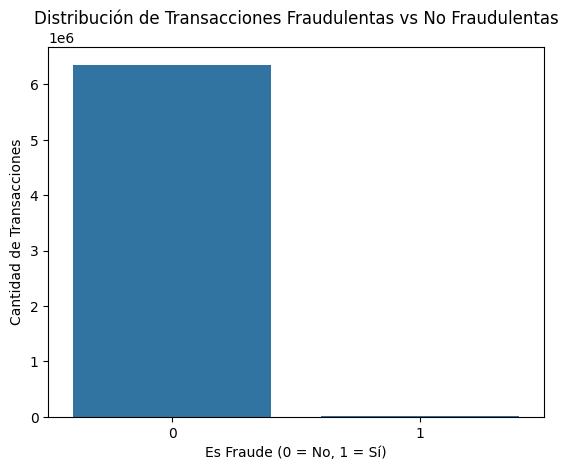

In [8]:
# Contar las clases en la variable objetivo ('isFraud')
fraud_counts = data['isFraud'].value_counts()
print("\nDistribución de clases:")
print(fraud_counts)  # Mostrar la distribución de clases (fraude vs no fraude)

# Visualizar la distribución de clases
sns.countplot(x='isFraud', data=data)  # Crear un gráfico de barras
plt.title('Distribución de Transacciones Fraudulentas vs No Fraudulentas')  # Título del gráfico
plt.xlabel('Es Fraude (0 = No, 1 = Sí)')  # Etiqueta del eje X
plt.ylabel('Cantidad de Transacciones')  # Etiqueta del eje Y
plt.show()  # Mostrar el gráfico

# *4.- Manejo del Desbalance de Clases*
Debido a que las transacciones fraudulentas son significativamente menos frecuentes que las no fraudulentas, utilizamos la técnica SMOTE (Synthetic Minority Over-sampling Technique) para balancear las clases y mejorar la capacidad del modelo para detectar fraudes.

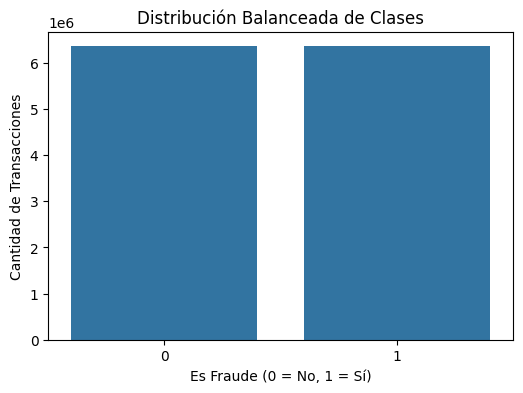


Desbalanceo corregido con SMOTE. Clases balanceadas.
isFraud
0    6354407
1    6354407
Name: count, dtype: int64


In [9]:
# Aplicar SMOTE para generar datos sintéticos y balancear las clases
smote = SMOTE(random_state=42)  # Crear una instancia de SMOTE con semilla
X_resampled, y_resampled = smote.fit_resample(X_scaled, y)  # Aplicar SMOTE a los datos

# Visualizar la nueva distribución de clases balanceadas
plt.figure(figsize=(6, 4))  # Configurar tamaño del gráfico
sns.countplot(x=y_resampled)  # Crear un gráfico de barras para las clases balanceadas
plt.title('Distribución Balanceada de Clases')  # Título del gráfico
plt.xlabel('Es Fraude (0 = No, 1 = Sí)')  # Etiqueta del eje X
plt.ylabel('Cantidad de Transacciones')  # Etiqueta del eje Y
plt.show()  # Mostrar el gráfico

# Mostrar conteo de clases después de balancear
print("\nDesbalanceo corregido con SMOTE. Clases balanceadas.")
print(pd.Series(y_resampled).value_counts())  # Imprimir la nueva distribución de clases

# *5.- Evaluación con Modelos Clásicos de Machine Learning*
Entrenamos y evaluamos modelos clásicos de machine learning.

In [10]:
# Definir los modelos clásicos para evaluar
models = {
    'Regresión Logística': LogisticRegression(),  # Regresión Logística
    'Árbol de Decisión': DecisionTreeClassifier(),  # Árbol de Decisión
    'CatBoost': CatBoostClassifier(iterations=100, learning_rate=0.1, verbose=0)  # CatBoost
}

# Dividir los datos balanceados en conjuntos de entrenamiento y prueba
X_train_classic, X_test_classic, y_train_classic, y_test_classic = train_test_split(
    X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled  # Mantener proporciones balanceadas
)

# Evaluar cada modelo clásico
for name, model in models.items():
    print(f"\nEvaluando modelo: {name}")  # Imprimir el nombre del modelo
    model.fit(X_train_classic, y_train_classic)  # Entrenar el modelo con datos de entrenamiento
    y_pred = model.predict(X_test_classic)  # Predecir en el conjunto de prueba

    # Mostrar el reporte de clasificación
    print(classification_report(y_test_classic, y_pred))  # Métricas de precisión, recall y F1-score


Evaluando modelo: Regresión Logística
              precision    recall  f1-score   support

           0       0.89      0.96      0.93   1270882
           1       0.96      0.88      0.92   1270881

    accuracy                           0.92   2541763
   macro avg       0.93      0.92      0.92   2541763
weighted avg       0.93      0.92      0.92   2541763


Evaluando modelo: Árbol de Decisión
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1270882
           1       1.00      1.00      1.00   1270881

    accuracy                           1.00   2541763
   macro avg       1.00      1.00      1.00   2541763
weighted avg       1.00      1.00      1.00   2541763


Evaluando modelo: CatBoost
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1270882
           1       1.00      1.00      1.00   1270881

    accuracy                           1.00   2541763
   macro avg       1.00 

# *6.- Preparación de Datos para PyTorch*
Convertimos los datos balanceados en tensores para entrenar modelos de PyTorch.



In [11]:
# Dividir los datos balanceados para PyTorch
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled
)

# Convertir las matrices en tensores para PyTorch
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)  # Tensor para características de entrenamiento
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)  # Tensor para etiquetas de entrenamiento
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)  # Tensor para características de prueba
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)  # Tensor para etiquetas de prueba

# Crear DataLoaders para manejar los datos en minibatches
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)  # Dataset para entrenamiento
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)  # Dataset para prueba
batch_size = 64  # Tamaño de lote
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)  # DataLoader de entrenamiento
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)  # DataLoader de prueba

# *7.- Entrenamiento del Modelo PyTorch*
## a.- Definir la arquitectura del modelo.

In [12]:
# Definir el modelo de detección de fraudes
class FraudDetectionModel(nn.Module):
    def __init__(self):
        super(FraudDetectionModel, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(X_train.shape[1], 64),  # Capa de entrada con 64 neuronas
            nn.ReLU(),  # Activación ReLU
            nn.Dropout(0.2),  # Dropout para prevenir sobreajuste
            nn.Linear(64, 32),  # Capa oculta con 32 neuronas
            nn.ReLU(),  # Activación ReLU
            nn.Dropout(0.2),  # Dropout
            nn.Linear(32, 1),  # Capa de salida con una neurona
            nn.Sigmoid()  # Activación sigmoide para salida binaria
        )

    def forward(self, x):
        return self.model(x)  # Definir la propagación hacia adelante

# Crear una instancia del modelo
model = FraudDetectionModel()

# Definir la función de pérdida y el optimizador
criterion = nn.BCELoss()  # Pérdida de entropía cruzada binaria
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)  # Optimizador Adam

## b.- Entrenamiento de Modelo, seteo de epocas y visualizacion de la perdida de entrenamiento.

Época [1/10], Pérdida de Entrenamiento: 0.0383
Época [2/10], Pérdida de Entrenamiento: 0.0307
Época [3/10], Pérdida de Entrenamiento: 0.0293
Época [4/10], Pérdida de Entrenamiento: 0.0278
Época [5/10], Pérdida de Entrenamiento: 0.0272
Época [6/10], Pérdida de Entrenamiento: 0.0265
Época [7/10], Pérdida de Entrenamiento: 0.0260
Época [8/10], Pérdida de Entrenamiento: 0.0257
Época [9/10], Pérdida de Entrenamiento: 0.0257
Época [10/10], Pérdida de Entrenamiento: 0.0250


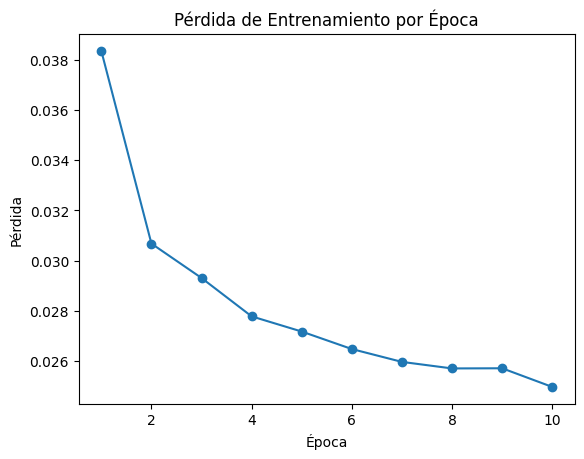

In [13]:
# Entrenar el modelo
num_epochs = 10  # Número de épocas
train_losses = []  # Lista para guardar las pérdidas por época
for epoch in range(num_epochs):
    model.train()  # Modo de entrenamiento
    running_loss = 0.0  # Inicializar la pérdida acumulada
    for features, labels in train_loader:  # Iterar sobre los lotes de datos
        outputs = model(features)  # Propagación hacia adelante
        loss = criterion(outputs.view(-1), labels)  # Calcular pérdida
        optimizer.zero_grad()  # Limpiar gradientes
        loss.backward()  # Backpropagation
        optimizer.step()  # Actualizar pesos
        running_loss += loss.item()  # Acumular pérdida
    epoch_loss = running_loss / len(train_loader)  # Promediar la pérdida
    train_losses.append(epoch_loss)  # Guardar la pérdida de la época
    print(f"Época [{epoch+1}/{num_epochs}], Pérdida de Entrenamiento: {epoch_loss:.4f}")

# Visualizar la pérdida de entrenamiento
plt.plot(range(1, num_epochs + 1), train_losses, marker='o')  # Crear gráfica de la pérdida
plt.title('Pérdida de Entrenamiento por Época')  # Título
plt.xlabel('Época')  # Etiqueta del eje X
plt.ylabel('Pérdida')  # Etiqueta del eje Y
plt.show()  # Mostrar gráfico

# *8. Evaluación del Modelo PyTorch*
Evaluamos el modelo entrenado y mostramos las métricas de rendimiento.


Reporte de clasificación del modelo PyTorch:
              precision    recall  f1-score   support

         0.0       1.00      0.99      0.99   1270882
         1.0       0.99      1.00      0.99   1270881

    accuracy                           0.99   2541763
   macro avg       0.99      0.99      0.99   2541763
weighted avg       0.99      0.99      0.99   2541763



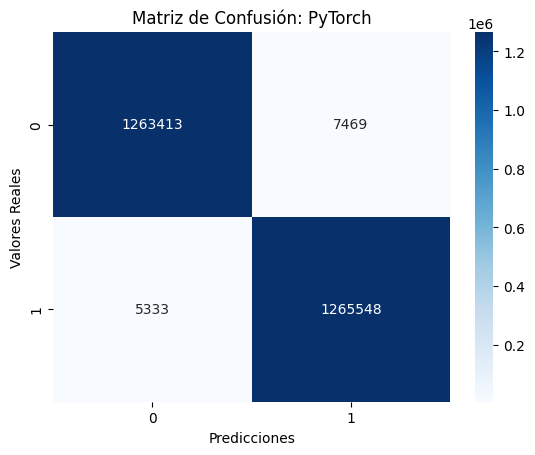

In [14]:
# Cambiar el modelo al modo de evaluación (desactiva dropout y batch normalization)
model.eval()

# Inicializar listas para almacenar las predicciones y etiquetas reales
all_preds = []  # Lista para las predicciones del modelo
all_labels = []  # Lista para las etiquetas reales

# Desactivar el cálculo de gradientes (reduce el uso de memoria y acelera el proceso)
with torch.no_grad():
    # Iterar sobre el DataLoader del conjunto de prueba
    for features, labels in test_loader:
        # Realizar la predicción
        outputs = model(features)  # Salidas del modelo
        # Convertir las probabilidades a etiquetas binarias (0 o 1) usando un umbral de 0.5
        preds = (outputs.view(-1) > 0.5).float()
        # Agregar las predicciones y etiquetas reales a las listas
        all_preds.extend(preds.numpy())
        all_labels.extend(labels.numpy())

# Generar el reporte de clasificación para evaluar el rendimiento del modelo
print("\nReporte de clasificación del modelo PyTorch:")
print(classification_report(all_labels, all_preds))

# Crear y visualizar la matriz de confusión
# Esto ayuda a identificar los verdaderos positivos, verdaderos negativos, falsos positivos y falsos negativos
cm = confusion_matrix(all_labels, all_preds)

# Visualización de la matriz de confusión como un mapa de calor
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Matriz de Confusión: PyTorch")
plt.xlabel("Predicciones")  # Etiqueta del eje X
plt.ylabel("Valores Reales")  # Etiqueta del eje Y
plt.show()


# *9.- Transformar un modelo PyTorch a Keras*
## a.- Exportar los pesos de PyTorch
Guarda los pesos del modelo de PyTorch entrenado.

In [21]:
# Guardar los pesos del modelo PyTorch
torch.save(model.state_dict(), "pytorch_model.pth")

## b.- Crear un modelo equivalente en Keras.

In [22]:
# Definir el modelo Keras con una arquitectura equivalente
keras_model = Sequential([
    Dense(64, input_dim=X_train.shape[1], activation='relu'),  # Capa densa equivalente a nn.Linear + nn.ReLU
    Dropout(0.2),  # Dropout
    Dense(32, activation='relu'),  # Capa oculta con 32 unidades
    Dropout(0.2),  # Dropout
    Dense(1, activation='sigmoid')  # Capa de salida con activación sigmoide
])


## c.- Convertir los pesos de PyTorch al modelo Keras.

In [23]:
def convert_pytorch_to_keras(pytorch_weights, keras_model):
    pytorch_keys = list(pytorch_weights.keys())  # Claves de los pesos en PyTorch
    keras_weights = []  # Lista para almacenar los pesos convertidos

    # Iterar sobre las capas del modelo Keras
    for layer in keras_model.layers:
        if isinstance(layer, Dense):  # Solo procesar capas Dense
            # Pesos de la capa densa
            weight = pytorch_weights[pytorch_keys.pop(0)].cpu().numpy().T  # Transponer pesos
            bias = pytorch_weights[pytorch_keys.pop(0)].cpu().numpy()  # Bias
            keras_weights.append([weight, bias])
        elif isinstance(layer, Dropout):
            # Dropout no tiene pesos, ignorar
            continue

    # Asignar los pesos al modelo Keras
    dense_layers = [layer for layer in keras_model.layers if isinstance(layer, Dense)]  # Filtrar solo capas Dense
    for layer, weights in zip(dense_layers, keras_weights):
        layer.set_weights(weights)  # Asignar pesos únicamente a las capas Dense

    return keras_model


## d.- Cargar los pesos del archivo guardado.

In [25]:
# Cargar los pesos del modelo guardado en PyTorch
pytorch_weights = torch.load("/content/pytorch_model.pth")
print("Pesos del modelo PyTorch cargados correctamente")

Pesos del modelo PyTorch cargados correctamente


<ipython-input-25-af6f2f127686>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pytorch_weights = torch.load("/content/pytorch_model.pth")


## e.- Después de cargar los pesos correctamente, ejecuta el código para convertirlos y asignarlos al modelo Keras:

In [27]:
# Convertir y asignar los pesos corregidos
keras_model = convert_pytorch_to_keras(pytorch_weights, keras_model)

# Guardar el modelo en formato Keras (.h5)
keras_model.save("keras_model.keras")
print("Modelo Keras guardado como keras_model.keras")

# Descargar una copia del modelo a tu máquina local
files.download("keras_model.keras")


Modelo Keras guardado como keras_model.keras


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## e.- Carga el modelo guardado y verifica que funcione correctamente en datos de prueba:

In [29]:
from tensorflow.keras.models import load_model

# Cargar el modelo Keras
loaded_model = load_model("/content/keras_model.keras")

# Realizar predicciones en el conjunto de prueba
predictions = loaded_model.predict(X_test)
print(predictions[:10])  # Mostrar las primeras 10 predicciones

79431/79431 ━━━━━━━━━━━━━━━━━━━━ 119s 1ms/step
[[9.5249993e-07]
 [1.0000000e+00]
 [9.9974853e-01]
 [0.0000000e+00]
 [1.0000000e+00]
 [0.0000000e+00]
 [1.3690405e-07]
 [1.7004400e-09]
 [1.0000000e+00]
 [9.9951410e-01]]


# *9.- Pruebas en modelo KERAS*
## a.- Predicciones vs. Valores Reales
Visualiza las predicciones comparadas con los valores reales (etiquetas verdaderas).

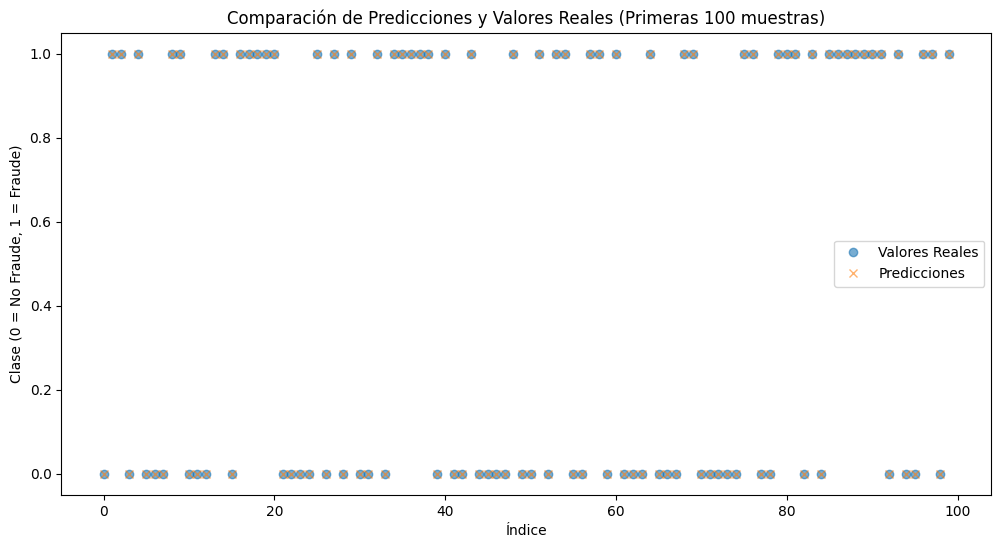

In [32]:
# Convertir predicciones a etiquetas binarias
predicted_labels = (predictions > 0.5).astype(int).flatten()

# Gráfico de comparación entre predicciones y valores reales
plt.figure(figsize=(12, 6))
plt.plot(y_test[:100].reset_index(drop=True), label="Valores Reales", marker='o', linestyle='', alpha=0.6)
plt.plot(predicted_labels[:100], label="Predicciones", marker='x', linestyle='', alpha=0.6)
plt.title("Comparación de Predicciones y Valores Reales (Primeras 100 muestras)")
plt.xlabel("Índice")
plt.ylabel("Clase (0 = No Fraude, 1 = Fraude)")
plt.legend()
plt.show()


## b.- Matriz de Confusión
La matriz de confusión te muestra los verdaderos positivos, verdaderos negativos, falsos positivos y falsos negativos.

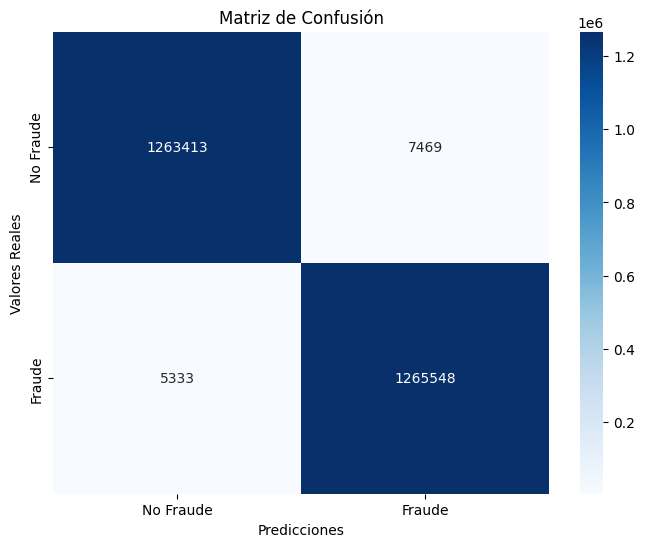

In [33]:
# Crear la matriz de confusión
cm = confusion_matrix(y_test, predicted_labels)

# Graficar la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["No Fraude", "Fraude"], yticklabels=["No Fraude", "Fraude"])
plt.title("Matriz de Confusión")
plt.xlabel("Predicciones")
plt.ylabel("Valores Reales")
plt.show()

## c.- Distribución de Probabilidades de Predicción*
Visualiza las probabilidades predichas por el modelo para entender mejor cómo se clasifican los datos.

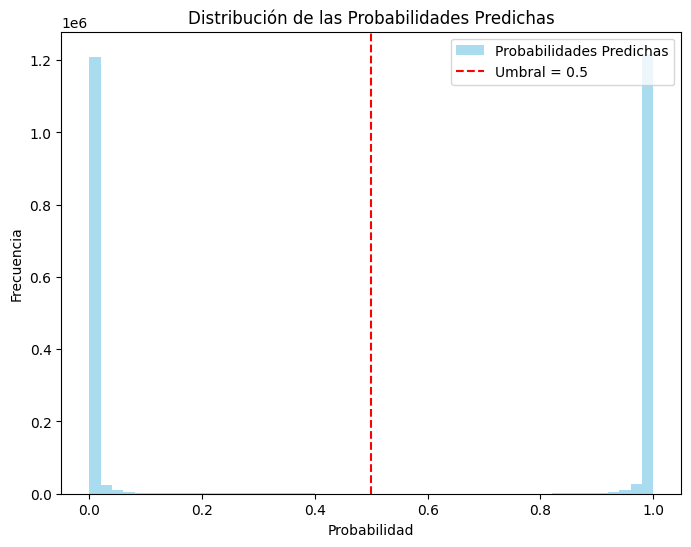

In [35]:
# Graficar distribución de probabilidades
plt.figure(figsize=(8, 6))
plt.hist(predictions, bins=50, alpha=0.7, label="Probabilidades Predichas", color="skyblue")
plt.axvline(0.5, color='red', linestyle='--', label="Umbral = 0.5")
plt.title("Distribución de las Probabilidades Predichas")
plt.xlabel("Probabilidad")
plt.ylabel("Frecuencia")
plt.legend()
plt.show()

# d.- Análisis de los Errores
Identifica cuáles son las muestras que el modelo predijo incorrectamente y visualízalas.

In [36]:
# Encontrar índices donde las predicciones fueron incorrectas
incorrect_indices = np.where(predicted_labels != y_test.reset_index(drop=True))[0]

# Mostrar algunas de las muestras mal clasificadas
print(f"Cantidad de errores: {len(incorrect_indices)}")
print(f"Primeras 5 muestras mal clasificadas:")
for i in incorrect_indices[:5]:
    print(f"Índice: {i}, Probabilidad Predicha: {predictions[i][0]:.2f}, Clase Real: {y_test.values[i]}")

Cantidad de errores: 12802
Primeras 5 muestras mal clasificadas:
Índice: 671, Probabilidad Predicha: 0.77, Clase Real: 0
Índice: 679, Probabilidad Predicha: 0.06, Clase Real: 1
Índice: 1504, Probabilidad Predicha: 0.05, Clase Real: 1
Índice: 1516, Probabilidad Predicha: 0.70, Clase Real: 0
Índice: 1683, Probabilidad Predicha: 0.12, Clase Real: 1
